# Coördinated Spiking Model ($\textit{d}$-dimensional input signal)

The following code simulates a Coördinated Spiking Model with $\textit{N}$ neurons and a $\textit{d}$-dimensional input. The model contains the following functions:

- initialize_params_N: initialize the variables and parameters for simulating the network
- TVS_N: creates sinusoidal input signal with $\textit{d}$ dimensions
- run_N: runs the spiking network model
- plot_N: plots the results (input + input estimate, spike trains and voltages)

Install required packages

In [9]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors

Function used for plotting the spike trains

In [10]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

## $\textit{N}$-neurons

Initialize parameters

In [371]:
def initialize_params_N(N, d, iterations, dt, D):
    """ Initialize variables and parameters. """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.zeros((d, iterations))

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = []
    
    for i in range(N):
        T.append((np.dot(D[i,:], D[i,:]))/2)
    
    return (t, voltage, x_est, o, T)

In [310]:
def TVS_N():
    "Create time varying signal following a sinusoidal function. "
    
    c = []
    x = []
    
    cycles = 4
    
    for i in range(d):
        x_temp = np.sin(np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + i * 1000)
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)
    
    if d > 1:
        c = np.asarray(c).reshape((d, iterations - 1))
        x = np.asarray(x).reshape((d, iterations))

    return(c, x)

In [375]:
def run_N(tau, beta):
    """ Run simulation with time constant, tau, and constant for the cost, beta. """
    
    for t in range(1, iterations):
        
        # update input estimate
        reset = np.zeros((1, d))
        
        for i in range(N):
             if o[i, t - 1] > 0:
                    reset = np.dot(D[i, :], o[i, t - 1])
           
        dxestdt = (-1/tau) * x_est[:, t - 1] + reset
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt

        # update voltage
        reset = np.zeros((1, N))
        
        for i in range(N):
             if o[i, t - 1] > 0:
                    reset = np.dot(D, D[i, :]) * o[i, t - 1]
                
        dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[:, t - 1]) - reset
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        above_threshold = []

        for i in range(N): 
            if voltage[i, t] > T[i]:
                above_threshold.append(i)

        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

In [427]:
def plot_N():
    """ Plots the results, including input and input estimate per dimension 
        as well as the spike trains and voltages of the individual neurons. """
    
    plot = d + N + 1
    pl.subplots(plot, 1, figsize=(12, 13))
    pl.subplots_adjust(hspace=0.4)
    
    # enable LaTeX
    pl.rc('text', usetex=True)
    
    counter = 1 
    
    # plot input and input estimate per dimension over time
    for i in range(1, d + 1):

        pl.subplot(plot, 1, counter)
        pl.plot(x_est[i - 1,:], label=r'$\hat{x}_{%i}$' %i, color='gray')
        pl.plot(x[i - 1,:], label='$x_{%i}$' %i, color='k')
        pl.yticks([])
        pl.xticks([])
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5),  fontsize=15)
        
        counter = counter + 1
    
    # plot spike trains per neuron over time
    pl.subplot(plot, 1, counter)
    
    for i in range(1, N + 1):
        
        values = zero_to_nan(o[i - 1, :] * i)
                
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='N%i' %i, s=1.5)
        pl.title('Spike train', fontsize=15)
        pl.yticks([])
        pl.xticks([])
        pl.ylim(0, 10 * N + 10)
        pl.xlim(0, iterations)
        
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=5)
    
    counter = counter + 1
    
    # plot voltage per neuron over time
    for i in range(1, N + 1):
        pl.subplot(plot, 1, counter)
        pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='voltage')
        pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
        pl.xlim(0, iterations)
        pl.ylabel('Voltage')
        pl.title('Neuron %i' %i,  fontsize=15)
        pl.yticks([])
        pl.xticks([])

        counter = counter + 1
        
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

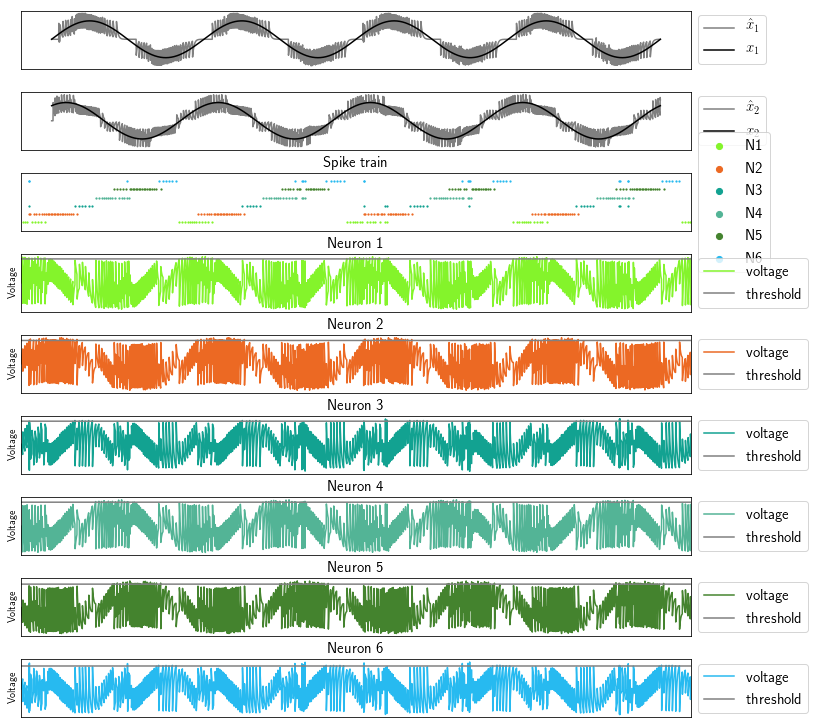

In [535]:
# Run simulation and plot results for given parameters
N = 6                                                    # number of neurons
d = 2                                                    # number of dimensions of signal input
iterations = 4000                                        # number of steps
dt = 0.1                                                 # step size
tau = 1                                                  # time constant
beta = 0                                                 # cost

# initialize decoding weights
D = []

weights = np.linspace(0, 2 * np.pi, N + 1)

for i in range(N):
    D_temp = [np.sin(weights[i]), np.cos(weights[i])]
    D.append(D_temp)
    
D = np.asarray(D).reshape((N, d))

color = list(np.random.choice(range(256), size=(N, 3)))

# run simulation
t, voltage, x_est, o, T = initialize_params_N(N, d, iterations, dt, D)      # initialize parameters
c, x = TVS_N()                                                              # create d-dimensional input signal
run_N(tau, beta)                                                            # run spiking network
plot_N()                                                                    # plot results

Plot the weights of the neurons for a 2-dimensional input

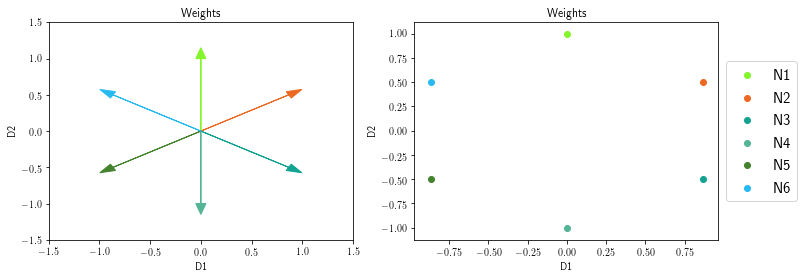

In [536]:
def plot_weights():
    """ Plot the weight for N neurons (presented as a scatter and arrow plot.). """
    
    plots = 2
    pl.subplots(plots, 1, figsize=(12, 4))
    
    # plot weights as arrows
    pl.subplot(1, 2, 1)
    for i in range(1, N + 1):
        arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
        
    pl.xlabel('D1')
    pl.ylabel('D2')
    pl.title('Weights')
    pl.xlim(-1.5, 1.5)
    pl.ylim(-1.5, 1.5)
    
    # plot weights as points
    pl.subplot(1, 2, 2)
    for i in range(1, N + 1):
        pl.scatter(D[i - 1][0], D[i - 1][1], color=color[i - 1][:]/255, label='N%i' %i)
        
    pl.xlabel('D1')
    pl.ylabel('D2')
    pl.title('Weights')
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        
plot_weights()

## Bounding box

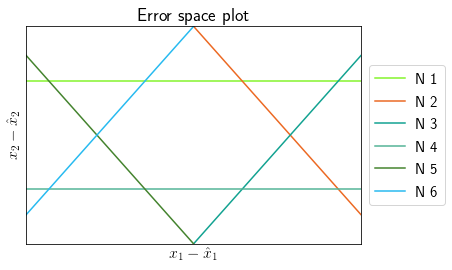

In [539]:
def bounding_box():
    
    # enable LaTeX
    pl.rc('text', usetex=True)
    
    steps = 10
    
    x1 = np.linspace(-10, 10, steps)
    
    for i in range(1, N + 1):
        x2 = np.zeros(steps)
        
        for j in range(steps):

            x2[j] = (T[i - 1] - x1[j] * D[i - 1, 0]) / D[i - 1, 1]

        pl.plot(x1, x2, label="N %i" %i, color=color[i - 1]/255)
        pl.xlim(-1, 1)
        pl.ylim(-1, 1)
        pl.yticks([])
        pl.xticks([])
        pl.xlabel('$x_{1} - \hat{x}_{1}$', fontsize=16)
        pl.ylabel('$x_{2} - \hat{x}_{2}$', fontsize=16)
        pl.title('Error space plot', fontsize=18)
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)

bounding_box()